In [4]:
#!python -m spacy download pl_core_news_lg
import pandas as pd
import numpy as np
import language_tool_python
import os
from datetime import datetime
import re
import tqdm
import random
from functions import *
from evaluation_functions import *
import pandas as pd
import itertools
from itertools import product
tool = language_tool_python.LanguageTool('pl')
import seaborn as sns
import matplotlib.pyplot as plt

## Introduction


* The following code aims at using pretrained polish BERT models for tweet classifications. 
* Dataset has been labeled to classify all netrual/not relevant tweets as neutral.
* This allows for filtering out noise - tweets that aren't aimed at specific company.
* Models used were chose based on the KLEJ bechmark t(https://klejbenchmark.com/leaderboard/).

### Preparing training dataset

In [5]:
all_columns = pd.read_csv(r'TrainingData\dataset_labeled.csv', nrows=0).columns.tolist()

columns_to_exclude = ['Unnamed: 0','Unnamed: 0.1' , 'Unnamed: 0.2']  # example columns to skip
wanted_columns = [col for col in all_columns if col not in columns_to_exclude]

dataset_labeled = pd.read_csv(r'TrainingData\dataset_labeled.csv', usecols=wanted_columns)

dataset_labeled['labels'] = dataset_labeled['labels'] + 1

dataset_labeled = dataset_labeled.dropna()
dataset_labeled = dataset_labeled.drop_duplicates(subset='text')

dataset_labeled['labels'] = dataset_labeled['labels'].astype(int)

In [17]:
dataset  = tokenize_datasets(dataset_labeled,'sdadas/polish-roberta-base-v2')

Map:   0%|          | 0/2025 [00:00<?, ? examples/s]

##### Training dataset is imbalanced what will be addressed in the later stage of the analysis. 

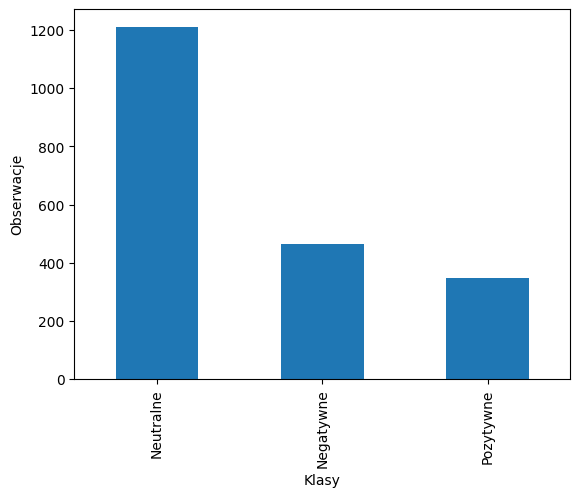

In [18]:
count = dataset_labeled['labels'].value_counts()
ax = count.plot(kind='bar')
ax.set_xlabel('Klasy')
ax.set_ylabel('Obserwacje')
ax.set_xticklabels(['Neutralne', 'Negatywne', 'Pozytywne'])  
plt.show()

Max length will be set as 128. It covers more than 95% of observations

In [19]:
%%capture --no-display
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tweet_lengths = [len(tokenizer.tokenize(tweet)) for tweet in dataset_labeled["text"]]

In [20]:
print(f"95th percentile: {np.percentile(tweet_lengths, 95)}")  
print(f"Max tokens: {max(tweet_lengths)}")

95th percentile: 77.0
Max tokens: 221


# Evaluating Text Preprocessing Strategies for BERT Classification


To evaluate the impact of different text preprocessing techniques on BERT model performance using a systematic comparison approach.

#### Methodology
A baseline BERT model with default parameters was trained on each preprocessed version of the datasets. Due to class imbalance and the focus on positive/negative classification, the F1 score serves as the primary evaluation metric.

#### Preprocessing Strategies
The first part was training the model with different basic preprocessing strategies.
Then we evaluated six distinct preprocessing approaches, incrementally adding complexity to assess the impact of each step:

1. Raw text without any preprocessing
2. Removal of non-textual characters
3. Conversion of emojis to corresponding text + Removal of non-textual characters
4. Removal of non-textual characters + Spelling correction
5. Removal of non-textual characters + Spelling correction + Lemmatization
6. Removal of non-textual characters + Spelling correction + Lemmatization + Stopword removal

Model performance is evaluated using the F1 score, which provides a balanced measure of precision and recall, particularly important for our imbalanced dataset classification task.

In [6]:
#Removing http
def preprocess_tweet_https(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    return tweet

#Removing hashtags
def preprocess_tweet_hashtag(tweet):
    tweet = re.sub(r'#\w+', ' ', tweet)
    return tweet

#Removing mentions
def preprocess_tweet_mention(tweet):
    tweet = re.sub(r'@\w+', ' ', tweet)
    return tweet

#Removing cashtag
def preprocess_tweet_cashtag(tweet):
    tweet = re.sub(r'\$\w+', ' ', tweet)
    return tweet

#Removing all charatcters except polish letter and ? !
def preprocess_tweet_text(tweet):
    tweet = re.sub(r'[^a-zA-ZĄąĆćĘęŁłŃńÓóŚśŹźŻż0-9\s?!]', ' ', tweet)
    return tweet

#Removing repeated letters
def preprocess_tweet_rep(tweet):
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    return tweet

#Removing white spaces
def preprocess_tweet_norm(tweet):
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

#Normalizing caps
def preprocess_caps(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'(^|[.!?]\s+)(\w)', lambda m: m.group(1) + m.group(2).upper(), tweet)
    return tweet

def preprocess_tco(tweet):
    return re.sub(r"https?://t\.co/\S+", "", tweet).strip()

In [7]:
# Processing pipelines
basic_processing_pipelines = {
    'No_processing': [],
    'No_processing_emoji': [
        replace_emoji
    ],
    'No_processing_http': [
        preprocess_tweet_https
    ],
    'No_processing_hashtag': [
        preprocess_tweet_hashtag
    ],
    'No_processing_mention': [
        preprocess_tweet_mention
    ],
    'No_processing_cashtag': [
        preprocess_tweet_cashtag
    ],
    'No_processing__text': [
        preprocess_tweet_text
    ],
    'No_processing__rep': [
        preprocess_tweet_rep
    ],
    'No_processing_norm': [
        preprocess_tweet_norm
    ],
    'No_processing_caps': [
        preprocess_caps
    ]
}

### Parameter setup

In [8]:
tested_models = {}
tested_models['ROBERT'] = "sdadas/polish-roberta-base-v2"
tested_models['HERBERT']  = "allegro/herbert-base-cased"
tested_models['POLBERT']  = "dkleczek/bert-base-polish-cased-v1"
tested_models['MBERT'] = 'google-bert/bert-base-multilingual-cased'

In [25]:
strat = {}
strat['No_processing'] = basic_processing_pipelines['No_processing']

In [30]:
datasets = transform_data(processing_pipelines = strat,dataset=dataset_labeled, csv_dir='TrainingData/')
tokenize_datasets = tokenize_datasets(datasets['No_processing'],model_name='allegro/herbert-base-cased')

TrainingData/processed_data_No_processing.csv


Map:   0%|          | 0/1973 [00:00<?, ? examples/s]

In [34]:
model = 'allegro/herbert-base-cased'

### Find best basic data preprocessing 

In [ ]:
os.path.exists(r'./preprocessing_comparison') or os.makedirs(r'./preprocessing_comparison')
os.path.exists(r'./results') or os.makedirs(r'./results')

datasets = transform_data(processing_pipelines = basic_processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')

params={'train_seed': [12], 'model_seed': [12,53,42]}
all_params = [dict(zip(params.keys(), values)) 
             for values in itertools.product(*params.values())]

all_combinations = list(product(all_params, tested_models.values(), datasets.keys()))

for params_set, model, dataset_name in tqdm.tqdm(all_combinations, desc="Grid Search", total=len(all_combinations)):
    try:
        print(f"Processing dataset: {dataset_name}")
        # Run cross-validation
        print(f"Running cross-validation with params: {params_set}")
        cv_results = cross_val_score(df=datasets[dataset_name], params = params_set, model_name=model, strategy_name=dataset_name)
        # Save results
        results_df = pd.DataFrame(cv_results, index=[0])
        results_df['model_seed'] = params_set['model_seed']
        results_df['train_seed'] = params_set['train_seed']
        results_df['model'] = model
        results_df['dataset'] = dataset_name
        timestamp = datetime.now().strftime('%Y%m%d_%''H%M%S')
        results_df.to_csv(rf"./preprocessing_comparison/preprocessing_comparison_model_{model[:4]}_{params_set['train_seed']}_{timestamp}.csv", index=False)
        print(f"\nComparison saved to preprocessing_comparison_model_{model[:4]}.csv")
       
    except Exception as e:
        print(f"Skipping failed params {params_set}: {str(e)}")

### Find best data preprocessing strategy

In [ ]:
# Based on the preprocessing steps
def preprocess_tweet(tweet):
    tweet = preprocess_tweet_mention(tweet)
    tweet = preprocess_tweet_https(tweet)
    return tweet

In [10]:
strategies_processing_pipelines = {
    'Basic_processing': [
        preprocess_tweet
    ],
    'Basic_processing_spelling': [
        preprocess_tweet,
        tool.correct
    ],
    'Basic_processing_spelling_lem': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text
    ],
    'Basic_processing_spelling_SP': [
        preprocess_tweet,
        tool.correct,
        remove_stops
    ],
    'Basic_processing_spelling_lem_SP': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text,
        remove_stops
    ]
}

In [ ]:
datasets = transform_data(processing_pipelines = strategies_processing_pipelines, dataset=dataset_labeled, csv_dir='TrainingData/')
os.path.exists(r'./strategy_comparison') or os.makedirs(r'./strategy_comparison')

datasets = transform_data(processing_pipelines = strategies_processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')

params={'train_seed': [12], 'model_seed': [12,53,42]}
all_params = [dict(zip(params.keys(), values)) 
             for values in itertools.product(*params.values())]

all_combinations = list(product(all_params, tested_models.values(), datasets.keys()))

for params_set, model, dataset_name in tqdm.tqdm(all_combinations, desc="Grid Search", total=len(all_combinations)):
    try:
        print(f"Processing dataset: {dataset_name}")
        # Run cross-validation
        print(f"Running cross-validation with params: {params_set}")
        cv_results = cross_val_score(df=datasets[dataset_name], params = params_set, model_name=model, strategy_name=dataset_name)
        # Save results  
        results_df = pd.DataFrame(cv_results, index=[0])
        results_df['model_seed'] = params_set['model_seed']
        results_df['train_seed'] = params_set['train_seed']
        results_df['model'] = model
        results_df['dataset'] = dataset_name
        timestamp = datetime.now().strftime('%Y%m%d_%' \
        'H%M%S')
        results_df.to_csv(rf"./strategy_comparison/preprocessing_comparison_model_{model[:4]}_{params['train_seed']}_{timestamp}.csv", index=False)
        print(f"\nComparison saved to preprocessing_comparison_model_{model[:4]}.csv")
       
    except Exception as e:
        print(f"Skipping failed params {params_set}: {str(e)}")

### Grid search with best preprocessing strategy


In [5]:
processing_pipelines = {}
processing_pipelines['Basic_processing'] = strategies_processing_pipelines['Basic_processing']

In [ ]:
N_SAMPLES = 150
dataset = transform_data(processing_pipelines = processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')
dataset_name = list(dataset.keys())[0]
os.path.exists(r'./grid_search_comparison') or os.makedirs(r'./grid_search_comparison')

model = tested_models['ROBERT']
param_grid = {
    "learning_rate": [1e-5,1.5e-5, 2e-5],     
    "batch_size": [4,8, 16],               
    "epochs": [3,4,5],                    
    "weight_decay": [0.05,0.01, 0.001],       
    "class_weight_floor": [0.5, 1.0],
    "train_seed": [42],  
    "model_seed": [42, 53, 12]
}
all_params = [dict(zip(param_grid.keys(), values)) 
             for values in itertools.product(*param_grid.values())]

sampled_params = random.sample(all_params, k=min(N_SAMPLES, len(all_params)))

for params_set in tqdm.tqdm(sampled_params, desc="Grid Search", total=len(sampled_params)):
    try:
        
        print(f"Processing dataset: {dataset_name}")
        # Run cross-validation
        print(f"Running cross-validation with params: {params_set}")
        cv_results = cross_val_score(df=dataset['Basic_processing'], params = params_set, model_name=model)
        # Save results  
        results_df = pd.DataFrame(cv_results, index=[0])
        results_df['model_seed'] = params_set['model_seed']
        results_df['train_seed'] = params_set['train_seed']
        results_df['model'] = model
        results_df['dataset'] = dataset_name
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        results_df.to_csv(rf"./grid_search_comparison/preprocessing_comparison_model_{model[:4]}_{params_set['model_seed']}_{timestamp}.csv", index=False)
        print(f"\nComparison saved to preprocessing_comparison_model_{model[:4]}.csv")
       
    except Exception as e:
        print(f"Skipping failed params {params_set}: {str(e)}")

# Final model training

In [21]:
params= {
    "learning_rate": 1.5e-5,     
    "batch_size": 4,               
    "epochs": 4,                    
    "weight_decay": 0.01,       
    "class_weight_floor": 1,
    "train_seed": 42,  
    "model_seed": 42
}


dataset_name = 'Basic_processing'
model_name = 'sdadas/polish-roberta-base-v2'
dataset = transform_data(processing_pipelines = {'Basic_processing': strategies_processing_pipelines['Basic_processing']}, dataset=dataset_labeled, csv_dir='TrainingData/')
dataset = dataset['Basic_processing']
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=params["train_seed"], stratify=dataset['labels'])
train_df_tokenized = tokenize_datasets(df = train_df, model_name=model_name, max_length=128, column='text')
val_df_tokenized = tokenize_datasets(df = test_df, model_name=model_name, max_length=128, column='text')

dataset_dict = DatasetDict({
        'train': train_df_tokenized,
        'test': val_df_tokenized
    })
try:
    
    print(f"Processing dataset: {dataset_name}")
    trainer, eval = train_evaluate(
        params=params, 
        tokenized_dataset=dataset_dict,
        model_name=model_name, 
    
    )
   
except Exception as e:
    print(f"Skipping failed params {params}: {str(e)}")

TrainingData/processed_data_Basic_processing.csv


Map:   0%|          | 0/1620 [00:00<?, ? examples/s]

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

Processing dataset: Basic_processing


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-roberta-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.922100,0.894115,0.659259,0.596269,0.657580,0.616034,0.737991,0.434783
2,0.783200,0.861295,0.718519,0.667966,0.720573,0.619355,0.798337,0.586207
3,0.553900,0.894779,0.735802,0.694064,0.737606,0.687500,0.797468,0.597222


In [22]:

def train_evaluate(params, tokenized_dataset, model_name):
    # Get and validate labels
    train_labels = np.array(tokenized_dataset["train"]["labels"])
    
    # Class weight calculation with floor
    class_weights = get_class_weights(train_labels, floor=params.get("class_weight_floor", 1.0))

    # Model initialization
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=3
    )
   
    # Training arguments with imbalance optimizations
    args = TrainingArguments(
        output_dir=f"./trained/{hash(str(params))}",
        num_train_epochs=params["epochs"],
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=32,
        learning_rate=params["learning_rate"],
        weight_decay=params["weight_decay"],
        warmup_ratio=0.1,  
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=False,
        metric_for_best_model="f1_weighted",
        greater_is_better=True,
        seed=params['model_seed'],
        optim="adamw_torch",
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=params.get("grad_accum_steps", 2),
        report_to="none",
        logging_steps=50,
        lr_scheduler_type="cosine",
         
    )

    # Initialize trainer
    trainer = WeightedTrainer(
        class_weights=class_weights,
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
        callbacks=[MasterCSVLoggerCallback(run_id=f'{model_name}_{"_".join(map(str, params.values()))}')], 
    )

    # Train with validation checks
    try:
        trainer.train()
        eval_results = trainer.evaluate()
        return trainer, eval_results
    except Exception as e:
        print(f"Training failed: {str(e)}")
        return None

In [ ]:
params= {
    "learning_rate": 1.5e-5,     
    "batch_size": 4,               
    "epochs": 5,                    
    "weight_decay": 0.01,       
    "class_weight_floor": 1,
    "train_seed": 42,  
    "model_seed": 42
}


dataset_name = 'Basic_processing'
model_name = 'sdadas/polish-roberta-base-v2'
dataset = transform_data(processing_pipelines = {'Basic_processing': strategies_processing_pipelines['Basic_processing']}, dataset=dataset_labeled, csv_dir='TrainingData/')
dataset = dataset['Basic_processing']
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=params["train_seed"], stratify=dataset['labels'])
train_df_tokenized = tokenize_datasets(df = train_df, model_name=model_name, max_length=128, column='text')
val_df_tokenized = tokenize_datasets(df = test_df, model_name=model_name, max_length=128, column='text')

dataset_dict = DatasetDict({
        'train': train_df_tokenized,
        'test': val_df_tokenized
    })
try:
    
    print(f"Processing dataset: {dataset_name}")
    trainer, eval = train_evaluate(
        params=params, 
        tokenized_dataset=dataset_dict,
        model_name=model_name, 
    
    )
   
except Exception as e:
    print(f"Skipping failed params {params}: {str(e)}")

In [ ]:
params= {
    "learning_rate": 1.5e-5,     
    "batch_size": 4,               
    "epochs": 5,                    
    "weight_decay": 0.01,       
    "class_weight_floor": 1.5,
    "train_seed": 42,  
    "model_seed": 42
}


dataset_name = 'Basic_processing'
model_name = 'sdadas/polish-roberta-base-v2'
dataset = transform_data(processing_pipelines = {'Basic_processing': strategies_processing_pipelines['Basic_processing']}, dataset=dataset_labeled, csv_dir='TrainingData/')
dataset = dataset['Basic_processing']
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=params["train_seed"], stratify=dataset['labels'])
train_df_tokenized = tokenize_datasets(df = train_df, model_name=model_name, max_length=128, column='text')
val_df_tokenized = tokenize_datasets(df = test_df, model_name=model_name, max_length=128, column='text')

dataset_dict = DatasetDict({
        'train': train_df_tokenized,
        'test': val_df_tokenized
    })
try:
    
    print(f"Processing dataset: {dataset_name}")
    trainer, eval = train_evaluate(
        params=params, 
        tokenized_dataset=dataset_dict,
        model_name=model_name, 
    
    )
   
except Exception as e:
    print(f"Skipping failed params {params}: {str(e)}")

In [ ]:
params= {
    "learning_rate": 1.5e-5,     
    "batch_size": 4,               
    "epochs": 4,                    
    "weight_decay": 0.01,       
    "class_weight_floor": 1.5,
    "train_seed": 42,  
    "model_seed": 42
}


dataset_name = 'Basic_processing'
model_name = 'sdadas/polish-roberta-base-v2'
dataset = transform_data(processing_pipelines = {'Basic_processing': strategies_processing_pipelines['Basic_processing']}, dataset=dataset_labeled, csv_dir='TrainingData/')
dataset = dataset['Basic_processing']
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=params["train_seed"], stratify=dataset['labels'])
train_df_tokenized = tokenize_datasets(df = train_df, model_name=model_name, max_length=128, column='text')
val_df_tokenized = tokenize_datasets(df = test_df, model_name=model_name, max_length=128, column='text')

dataset_dict = DatasetDict({
        'train': train_df_tokenized,
        'test': val_df_tokenized
    })
try:
    
    print(f"Processing dataset: {dataset_name}")
    trainer, eval = train_evaluate(
        params=params, 
        tokenized_dataset=dataset_dict,
        model_name=model_name, 
    
    )
   
except Exception as e:
    print(f"Skipping failed params {params}: {str(e)}")